In [1]:
import os
import numpy as np
import lancet
import holoviews as hv

from featuremapper.analysis.raster import fft_power
from featuremapper.analysis.pinwheels import PinwheelAnalysis
from featuremapper.analysis.hypercolumns import PowerSpectrumAnalysis
from topo.analysis.command import *
from analysis import *

import topo
from topo.analysis import Collector
from topo.submodel.scal import ModelSCAL
from topo.submodel.gcal import ArraySpec

from topo.command import runscript  # In order to check the model files load correctly
from topo.misc.lancext import RunBatchCommand, topo_metadata

hv.notebook_extension()

In [2]:
import numbergen

# Experimental Setup

In [3]:
batch_name = 'SCAL_lateral'

# Model options
laterals = True

# Measurements
isosuppression = False
sizetuning = False
frequencytuning = False
complexity = False
isosuppression = False
flankers = False
rfs = False

# Define times
times = [1000*i for i in range(21)]
print("Collection times start at %s and end at %s" % (min(times), max(times)))

# Define Args

constants = lancet.Args(area=3.0, aff_strength=2.4, exc_strength=1.6, inh_strength=1.8)
parameter_space = lancet.Range('latexc_strength', 0, 3.0, 11) * lancet.Range('contrast', 10, 100, 10)
batch_arguments =  constants * parameter_space * lancet.Args(times=times)

Collection times start at 0 and end at 20000


## Load the model

In [4]:
topo.sim.model = ModelSCAL(laterals=False, area=1.0)
scal = topo.sim.model.specification

In [7]:
c = Collector()

# Projection activities
c.Activity.LGNOnAfferent =  c.collect(scal.projections.V1.LGNOnAfferent)
c.Activity.LGNOffAfferent = c.collect(scal.projections.V1.LGNOffAfferent)

# OR preference measurement
c.collect(measure_or_pref)
# Sheet activities
c.Activity.Retina =         c.collect(scal.sheets.Retina)
c.Activity.V1 =             c.collect(scal.sheets.V1)
# Connection fields
c.CFs.LGNOnAfferent =       c.collect(scal.projections.V1.LGNOnAfferent,  grid=True)
c.CFs.LGNOffAfferent =      c.collect(scal.projections.V1.LGNOffAfferent, grid=True)
c.CFs.LateralInhibitory =   c.collect(scal.projections.V1.LateralInhibitory, grid=True)
c.CFs.LateralExcitatory =   c.collect(scal.projections.V1.LateralExcitatory, grid=True)
if laterals:
    c.CFs.LRExcitatory =   c.collect(scal.projections.V1.LRExcitatory, grid=True)

# Homeostatic threshold
c.HomeostaticThreshold.V1 = c.collect(ArraySpec('V1.output_fns[0].t'), 
                                                group='Homeostatic Threshold')

# OR preference measurement
c.collect(measure_or_pref, frequencies=[1.4, 1.6, 1.8])
c.collect(measure_response, durations=list(np.linspace(0,1,21)))

if rfs:
    c.collect(measure_rfs, roi=(-.25, -.25, .25, .25), presentations=5000, scale=2, times=[times[-1]])

# Times and coords for further measurements
coords=[(0,-0.1),(-0.1,0.0),(0,0),(0,0.1),(0.1,0.0)]
frequency=1.5

# Analysis
c.Pinwheels.V1 =            c.analyze(c.ref.OrientationPreference.V1
                                         * c.ref.OrientationSelectivity.V1, PinwheelAnalysis)
c.FFTAnalysis.V1 =          c.analyze(c.ref.OrientationPreference.V1, PowerSpectrumAnalysis)

## Launcher

In [10]:
# Local or on cluster
QSUB = True
# Open diff in pager or not
SHOW_DIFF = True

ty_file = './scal_divisive.ty'
metadata = topo_metadata()
output_directory = os.path.join(os.getcwd(), 'data')

lancet.review_and_launch.output_directory = output_directory

qsub_options = dict(b='y',
                    pe=('sharedmem', '4'),   # Parallel environment allocation
                    v='OMP_NUM_THREADS=4')   # Must match slot allocation above.

@lancet.review_and_launch()
def launch():
    runbatch_cmd = RunBatchCommand(ty_file, c, metadata=batch_arguments.varying_keys, snapshot=False)
    Launcher = lancet.QLauncher if QSUB else lancet.Launcher
    return Launcher(batch_name, batch_arguments, runbatch_cmd,  metadata=metadata(), 
                    **({'qsub_flag_options':qsub_options} if QSUB else {}))
launch()


| Arguments Summary |

Items: 110
Varying Keys: 'latexc_strength', 'contrast'
Constant Items: aff_strength=2.4, area=3.0, cortex_density=47, exc_strength=1.6, inh_strength=1.8, laterals=True, lgn_density=16, times=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]

Show available argument specifier entries? [y, N, quit]: 

| RunBatchCommand Summary |

Command executable: /exports/eddie/scratch/s1048519/topographica/topographica
Collector definition summary:

15 tasks scheduled:

  01.  Activity.LGNOnAfferent
           ProjectionSpec
  02.  Activity.LGNOffAfferent
           ProjectionSpec
  03.  [...] 
          measure_or_pref
  04.  Activity.Retina
           SheetSpec
  05.  Activity.V1
           SheetSpec
  06.  CFs.LGNOnAfferent
           ProjectionSpec [grid=True]
  07.  CFs.LGNOffAfferent
           ProjectionSpec [grid=True]
  08.  CFs.LateralInhibitory
           ProjectionSpec [grid=True]


Time: 000000.00 QLauncher: Invoked qsub for 110 commands


True

# Results and Analysis

In [5]:
from holoviews.core.io import Unpickler
from analysis.progress import ProgressWidget, load_table

In [6]:
hv.notebook_extension('bokeh')

In [7]:
path = './data/2016-05-11_0049-SCAL_lateral'
table = load_table(path)
data = Unpickler.collect(table, drop=['time', 'Index', 'tid', 'timestamps'])
ProgressWidget(path)

:Layout
   .DynamicMap.I   :DynamicMap   [Time]
   .DynamicMap.II  :DynamicMap   [Time]
   .DynamicMap.III :DynamicMap   [Time]
   .DynamicMap.IV  :DynamicMap   [Time]

## Robustness - Similarity, Selectivity, Map quality

In [8]:
hv.notebook_extension('matplotlib')
%output widgets='live'

In [9]:
dims = ['latexc_strength', 'contrast']

In [9]:
%%output fig='svg'
lgn_on  = data.CFs.LGNOnAfferent.select(time=20000, contrast=(10, 50), latexc_strength=(0, 1))()
lgn_off = data.CFs.LGNOffAfferent.select(time=20000, contrast=(10, 50), latexc_strength=(0, 1))()
lgn_on * lgn_off

:GridSpace   [X,Y]
   :HoloMap   [dataset,Time]
      :Overlay
         .CF_Weight.LGNOnAfferent  :CFView   [x,y]   (z)
         .CF_Weight.LGNOffAfferent :CFView   [x,y]   (z)

In [10]:
orpref = data.OrientationPreference.V1() 
orsel  = data.OrientationSelectivity.V1()

### Similarity

In [11]:
hv.notebook_extension('matplotlib')

In [10]:
from holoviews.operation.normalization import raster_normalization
def similarity_analysis(hmap):
    return transform(cyclic_difference(raster_normalization(hmap*hmap.last)), operator=lambda x: 1.0-(2.0*x))

In [11]:
dims = ['latexc_strength', 'contrast']
maps = orpref.reindex(dims+['Time']).groupby(dims)
similarity = hv.HoloMap(kdims=dims)
for k, m in maps.items():
    if 20000 in m.keys():
        similarity[k] = hv.Table(similarity_analysis(m).reduce(['x', 'y'], np.mean), datatype=['dataframe']).to.curve(['Time'], ['z'])

:HeatMap   [latexc_strength,contrast]   (Stability)
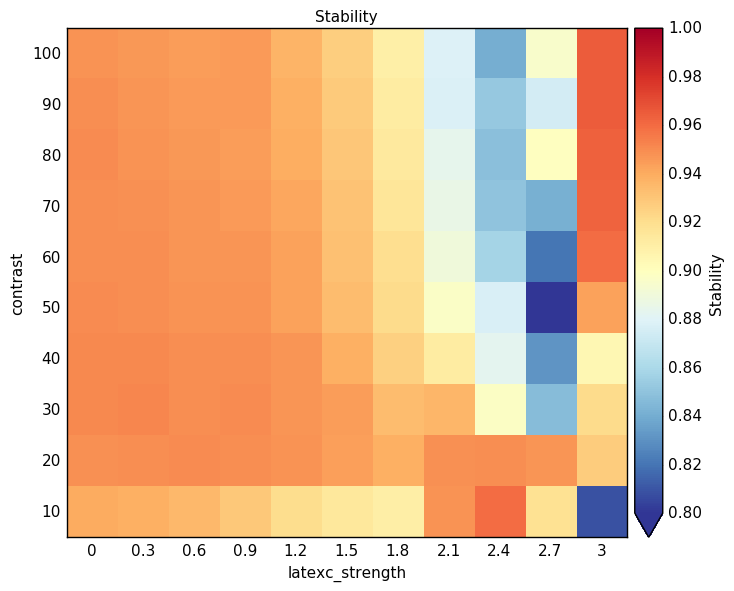

In [12]:
%%output size=200 dpi=100
%%opts HeatMap (clims=(0.8, 1)) [colorbar=True show_values=False]
similarity_hm = similarity.reduce(['Time'], np.mean).table(datatype='dataframe').to.heatmap(dims, ['z'], group='Stability')
similarity_hm.data = similarity_hm.data.rename(columns={'z': 'Stability'})
similarity_hm.vdims = [hv.Dimension('Stability')]
similarity_hm

## Selectivity

In [13]:
dims = ['latexc_strength', 'contrast']
maps = orsel.reindex(['Time']+dims).groupby(dims)
selectivity = hv.HoloMap(kdims=dims)
for k, sel in maps.items():
    if 20000 in sel.keys():
        selectivity[k] = sel.reduce(['x', 'y'], np.mean)

:HeatMap   [latexc_strength,contrast]   (Orientation Selectivity)
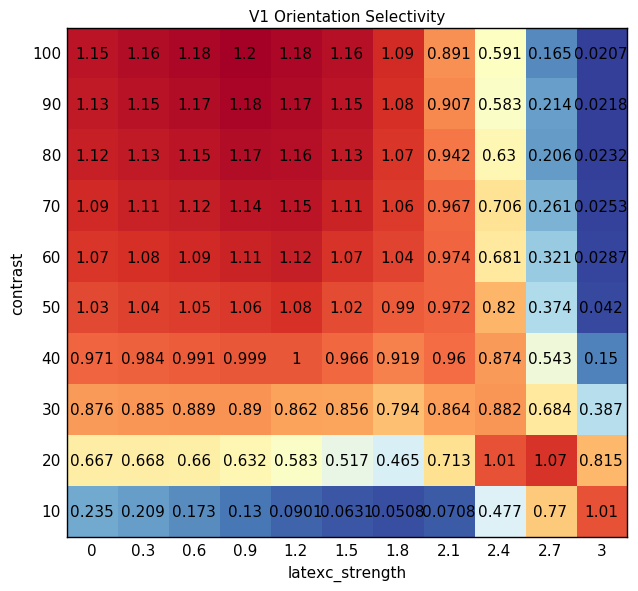

In [14]:
%%output size=200 dpi=100
%%opts HeatMap (clims=(0, 1.2))
selectivity_hm = selectivity.reduce(['Time'], np.mean).to.heatmap(group='Orientation Selectivity')
selectivity_hm.vdims = [hv.Dimension('Orientation Selectivity', value_format=lambda x: '%.3g' % x)]
selectivity_hm.sort()

## Pinwheel Density

In [16]:
orpref_20k = orpref.select(Time=20000, x=(-1, 1), y=(-1, 1))

In [17]:
pinwheel_results = hv.HoloMap(kdims=dims)
for k, group in orpref_20k.groupby(dims).items():
    try:
        pinwheel_results[k] = PowerSpectrumAnalysis(group, gamma_k=3.0)
    except Exception as e:
        print e
        pass
pinwheel_results = pinwheel_results.collate()
pwd_metrics = pinwheel_results.PowerSpectrum_Analysis.V1.dframe()

/Users/philippjfr/miniconda/envs/science/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
Time: 000000.00 PinwheelAnalysis: Contour identification failed:
zero-size array to reduction operation minimum which has no identity
Time: 000000.00 PinwheelAnalysis: Contour identification failed:
zero-size array to reduction operation minimum which has no identity
Time: 000000.00 PinwheelAnalysis: Contour identification failed:
zero-size array to reduction operation minimum which has no identity
Time: 000000.00 PinwheelAnalysis: Contour identification failed:
zero-size array to reduction operation minimum which has no identity
Time: 000000.00 PinwheelAnalysis: Contour identification failed:
zero-size array to reduction operation minimum which has no identity
Time: 000000.00 PinwheelAnalysis: Contour identification failed:
zero-size array to reduction operation minimum which has no identity

:Layout
   .Pinwheel_Density.I        :HeatMap   [latexc_strength,contrast]   (rho)
   .Pinwheel_Density_Metric.I :HeatMap   [latexc_strength,contrast]   (rho_metric)
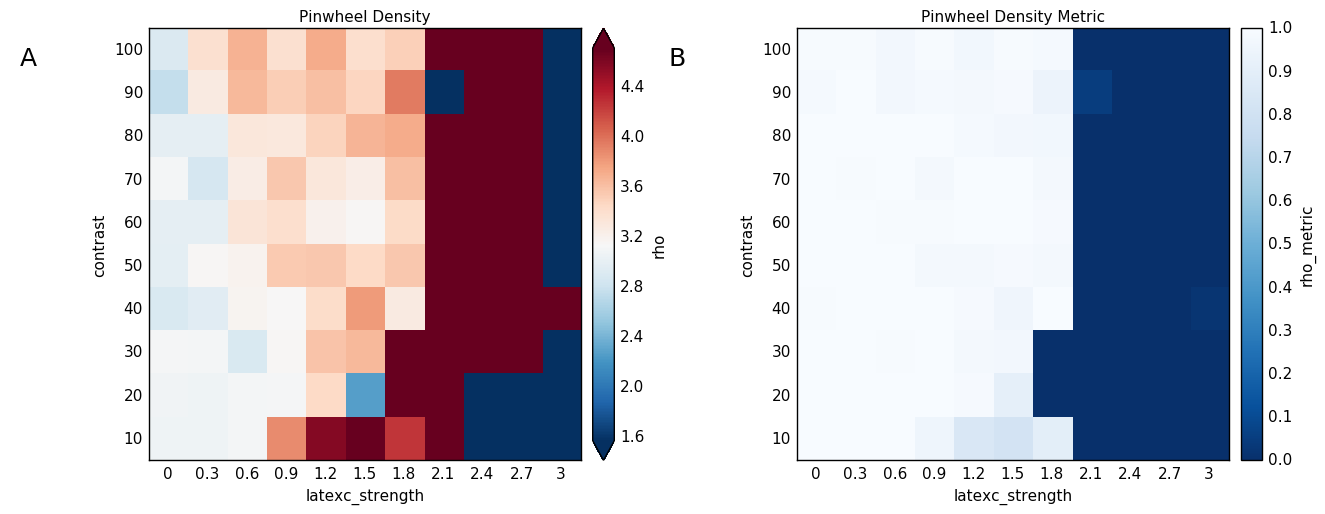

In [18]:
%%output size=150 dpi=100
%%opts HeatMap.Pinwheel_Density (clims=(np.pi/2.,np.pi*1.5) cmap='RdBu_r') [show_values=False colorbar=True]
%%opts HeatMap.Pinwheel_Density_Metric (clims=(0, 1) cmap='Blues_r') [show_values=False colorbar=True]
pwdm = hv.Table(pwd_metrics).to.heatmap(dims, ['rho_metric'], [], group='Pinwheel Density Metric')
pwd = hv.Table(pwd_metrics).to.heatmap(dims, ['rho'], [], group='Pinwheel Density')
pwd + pwdm

### Local Homogeneity Index

In [19]:
import analysis

In [20]:
lhi_20k = analysis.LocalHomogeneityIndex(orpref_20k)
lhi_table = lhi_20k.reduce(function=np.mean)

:HoloMap   [Time,Duration]
   :HeatMap   [latexc_strength,contrast]   (LHI)
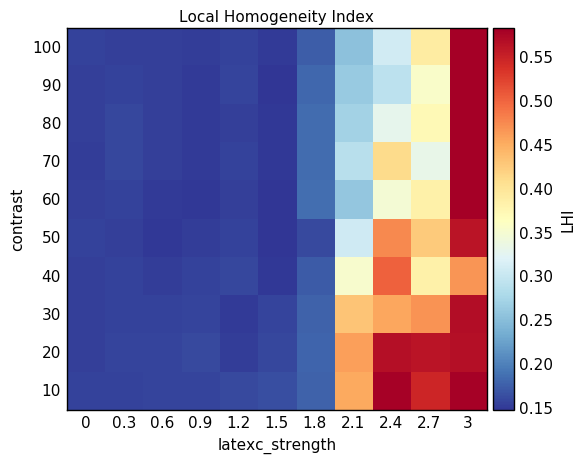

In [21]:
%%output size=150 dpi=100
%%opts HeatMap [show_values=False colorbar=True]
lhi = lhi_table.to.heatmap(dims).relabel(label='')
lhi

## Center-of-Gravity Shift

In [22]:
lgn_on = data.CFs.LGNOnAfferent.select(time=20000)().select(X=(-1, 1), Y=(-1, 1))
grouped_cfs = hv.Collator(lgn_on, merge_type=hv.HoloMap, kdims=lgn_on.kdims)().reindex().groupby(dims)

In [44]:
np.sum(cf_df.z)

0.50963187

In [83]:
distance_map = {}
for (tc, exp), group in grouped_cfs.items():
    if len(group):
        total_distance = 0
    else:
        total_distance = np.NaN
    for (x, y), cf in group.items():
        cf_df = cf.dframe()
        normed_weights = cf_df.z/np.sum(cf_df.z)
        cogx = np.sum(cf_df.x * normed_weights)
        cogy = np.sum(cf_df.y * normed_weights)
        total_distance += np.sqrt(((cogx - x)**2) + ((cogy - y)**2))
    distance_map[tc, exp] = total_distance/len(group)

:HeatMap   [latexc_strength,contrast]   (CoG Shift)
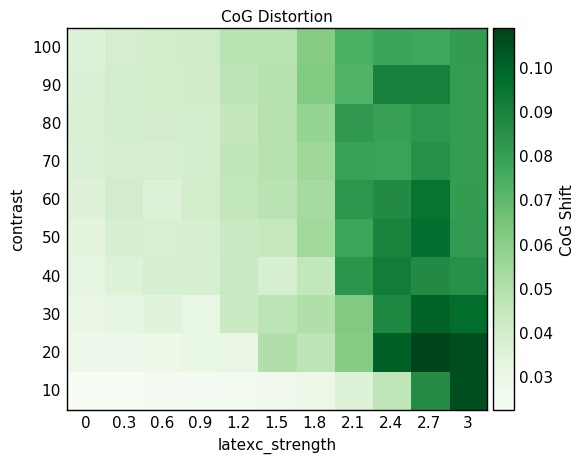

In [84]:
%%output size=150 dpi=100
%%opts HeatMap [show_values=False colorbar=True] (cmap='Greens')
cog = hv.HeatMap(distance_map, group='CoG Distortion', kdims=dims, vdims=['CoG Shift']).sort()
cog

### Overview

In [28]:
%%output size=150 dpi=100 fig='svg' filename='SCAL_Robustness'
%%opts Layout [hspace=0.5 vspace=0.]
%%opts HeatMap [sublabel_position=(-0.25, 0.9) show_frame=True colorbar=True sublabel_size=24 fontsize={'title':20,'xlabel':16,'ylabel':16,'ticks':16} show_values=False] {+framewise}
%%opts HeatMap.Stability (cmap='Blues' clims=(0.8, 1)) [cbar_ticks=[0.8, 0.85, 0.9, 0.95, 1]]
%%opts HeatMap.Orientation_Selectivity (cmap='Reds' clims=(0, 10))
%%opts HeatMap.Local_Homogeneity_Index (cmap='Purples' clims=(0, 0.5)) [cbar_extend='max']
%%opts HeatMap.Pinwheel_Density [cbar_ticks=[(np.pi/2., r'$\pi/2$'), (np.pi, r'$\pi$'), (np.pi, r'$\pi$'), (np.pi*1.5, r'$3(\pi/2)$')]] (cmap='RdBu_r')
%%opts HeatMap.CoG_Distortion (clims=(0, 0.4))
linearity = similarity_hm + selectivity_hm.clone(label='') + lhi.last + pwd + cog
linearity.cols(3) 

:Layout
   .Stability.I               :HeatMap   [latexc_strength,contrast]   (Stability)
   .Orientation_Selectivity.I :HeatMap   [latexc_strength,contrast]   (Orientation Selectivity)
   .Local_Homogeneity_Index.I :HeatMap   [latexc_strength,contrast]   (LHI)
   .Pinwheel_Density.I        :HeatMap   [latexc_strength,contrast]   (rho)
   .CoG_Distortion.I          :HeatMap   [latexc_strength,contrast]   (CoG Shift)

#### Figure 5.9: 

Parameter explorations of three separate metrics of orientation map development using the SCAL model from Chapter 4. Plotted on x and y are the strength of long-range lateral excitation and the stimulus contrast during training. The three metrics are A the ρ pinwheel density metric, which characterizes the quality of the map, B the average selectivity over the time course of development, and C the stability metric, measuring how much the map changes throughout the course of development. The model is highly robust to varying stimulus contrasts at low levels of lateral excitation, but quickly deteriorates with increasing levels of excitation. Pure white values indicate instabilities in the model causing the model to terminate.

In [30]:
metrics = None
for metric in linearity + pwdm:
    if metrics is None:
        metrics = metric.dframe()
    else:
        metrics = metrics.merge(metric.dframe(), on=dims)

In [33]:
%%output size=200 fig='svg' filename='SCAL_Robustness_Correlations'
%%opts Overlay [xrotation=90 invert_yaxis=True show_frame=False] VLine (color='w' lw=7) HLine (color='w' lw=7)
%%opts HeatMap [colorbar=True show_values=False ] (clims=(-1, 1) cmap='RdBu_r')
corr = metrics.corr()
corr = corr.reindex_axis([c for c in sorted(corr.columns) if c != 'rho'], axis=1)
hv.HeatMap([((c, c2), corr[c][c2] if c != c2 else np.NaN) for i, c in enumerate(corr)
            for c2 in corr.columns[i+1:]], kdims=[' ', '  '],  vdims=['Pearson Correlation']) *\
hv.Overlay([hv.VLine(i) for i in range(7)]) * hv.Overlay([hv.HLine(i) for i in range(7)])

:Overlay
   .HeatMap.I :HeatMap   [ ,  ]   (Pearson Correlation)
   .VLine.I   :VLine   [x,y]
   .VLine.II  :VLine   [x,y]
   .VLine.III :VLine   [x,y]
   .VLine.IV  :VLine   [x,y]
   .VLine.V   :VLine   [x,y]
   .VLine.VI  :VLine   [x,y]
   .VLine.VII :VLine   [x,y]
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]
   .HLine.IV  :HLine   [x,y]
   .HLine.V   :HLine   [x,y]
   .HLine.VI  :HLine   [x,y]
   .HLine.VII :HLine   [x,y]

#### Figure 5.10: 

A correlation matrix of the various dependent and independent variables of the linearity analysis. Plots the Pearson correlation of each variable against each other variable, for the SCAL model from Chapter 4.